In [1]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00


NameError: name 'datetime' is not defined

In [3]:
import datetime
import math
import yfinance as yf
import pandas as pd
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 9, 30)
stock_data = yf.download("AAPL", start, end)
stock_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.568928,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.561859,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.750271,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.214226,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.061142,82271200
...,...,...,...,...,...,...
2024-09-23,227.339996,229.449997,225.809998,226.470001,226.470001,54146000
2024-09-24,228.649994,229.350006,225.729996,227.369995,227.369995,43556100
2024-09-25,224.929993,227.289993,224.020004,226.369995,226.369995,42308700


In [4]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-23,227.339996,229.449997,225.809998,226.470001,226.470001,54146000
2024-09-24,228.649994,229.350006,225.729996,227.369995,227.369995,43556100
2024-09-25,224.929993,227.289993,224.020004,226.369995,226.369995,42308700
2024-09-26,227.300003,228.500000,225.410004,227.520004,227.520004,36636700
2024-09-27,228.460007,229.520004,227.300003,227.789993,227.789993,34026000


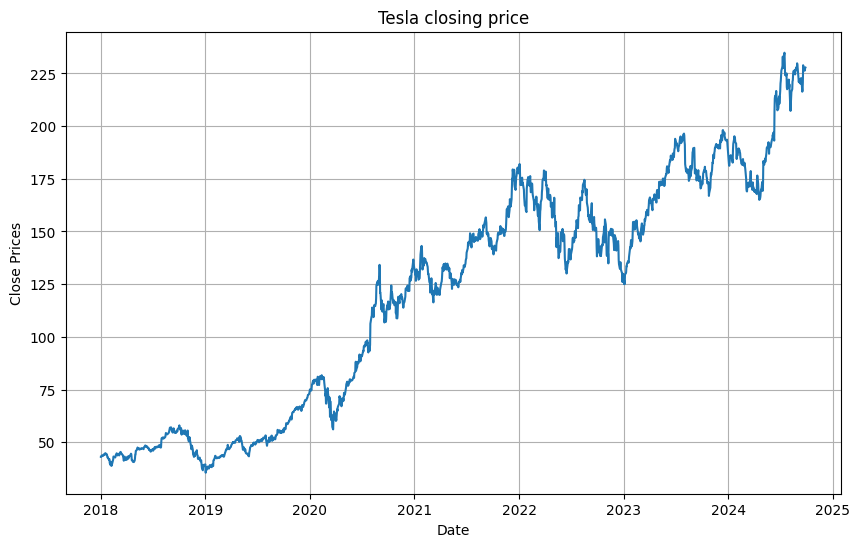

In [6]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Tesla closing price')
plt.show()

Date
2018-01-02     43.064999
2018-01-03     43.057499
2018-01-04     43.257500
2018-01-05     43.750000
2018-01-08     43.587502
                 ...    
2024-09-23    226.470001
2024-09-24    227.369995
2024-09-25    226.369995
2024-09-26    227.520004
2024-09-27    227.789993
Name: Close, Length: 1696, dtype: float64


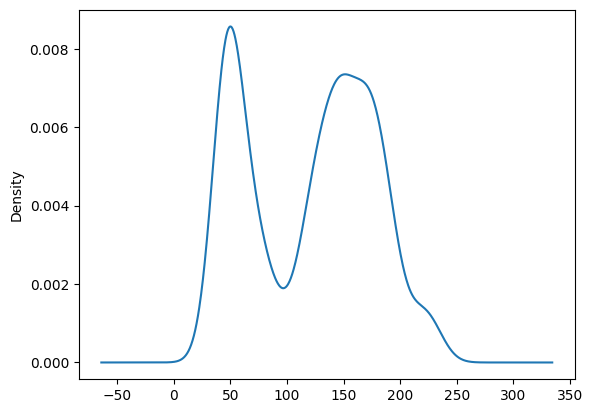

In [8]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')
print (df_close)

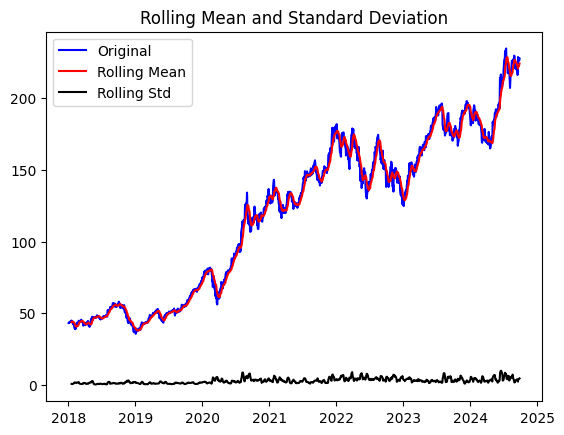

Results of dickey fuller test
Test Statistics                  -0.315415
p-value                           0.923293
No. of lags used                  0.000000
Number of observations used    1695.000000
critical value (1%)              -3.434214
critical value (5%)              -2.863247
critical value (10%)             -2.567679
dtype: float64


In [16]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

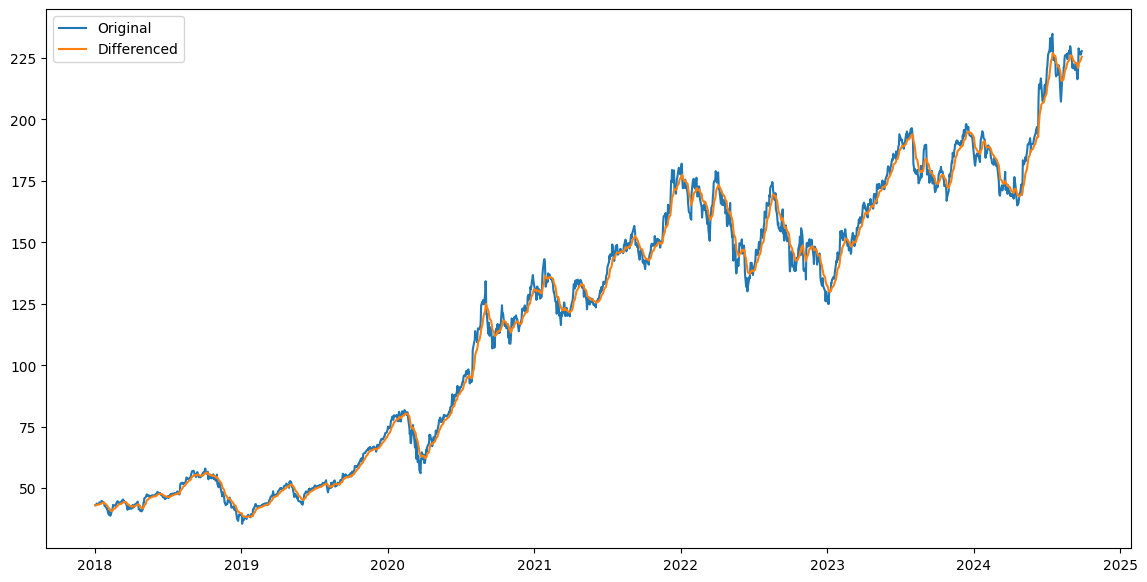

In [17]:

df_ewm = df_close.ewm(span=12, adjust=False).mean()
ts_diff = df_ewm.diff().dropna()

# Plot original and differenced series
plt.figure(figsize=(14, 7))
plt.plot(df_close, label='Original')
plt.plot(df_ewm, label='Differenced')
plt.legend()
plt.show()

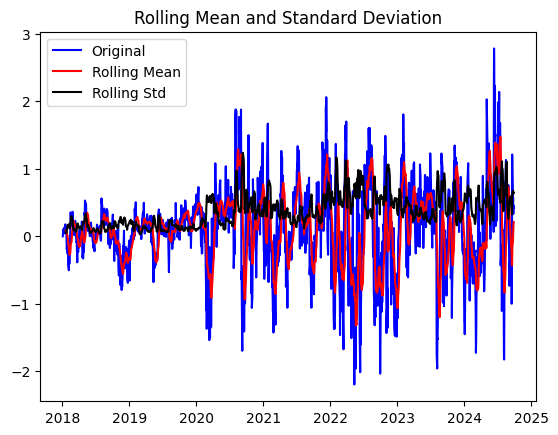

Results of dickey fuller test
Test Statistics               -1.245185e+01
p-value                        3.560902e-23
No. of lags used               0.000000e+00
Number of observations used    1.694000e+03
critical value (1%)           -3.434216e+00
critical value (5%)           -2.863248e+00
critical value (10%)          -2.567679e+00
dtype: float64


In [18]:
test_stationarity(ts_diff)

In [19]:
ts_diff

,Close
Date,
2018-01-03,-0.001154
2018-01-04,0.029793
2018-01-05,0.100979
2018-01-08,0.060444
2018-01-09,0.050375
...,...
2024-09-23,0.513993
2024-09-24,0.573378
2024-09-25,0.331320


Date
2018-01-03   -0.001154
2018-01-04    0.029793
2018-01-05    0.100979
2018-01-08    0.060444
2018-01-09    0.050375
                ...   
2022-09-13   -0.911301
2022-09-14   -0.544947
2022-09-15   -0.913417
2022-09-16   -1.029814
2022-09-19   -0.289843
Name: Close, Length: 1186, dtype: float64
Date
2022-09-20    0.127056
2022-09-21   -0.381721
2022-09-22   -0.473763
2022-09-23   -0.756263
2022-09-26   -0.587605
                ...   
2024-09-23    0.513993
2024-09-24    0.573378
2024-09-25    0.331320
2024-09-26    0.457272
2024-09-27    0.428459
Name: Close, Length: 509, dtype: float64
Date
2022-09-21    153.720001
2022-09-22    152.740005
2022-09-23    150.429993
2022-09-26    150.770004
2022-09-27    151.759995
                 ...    
2024-09-23    226.470001
2024-09-24    227.369995
2024-09-25    226.369995
2024-09-26    227.520004
2024-09-27    227.789993
Name: Close, Length: 508, dtype: float64


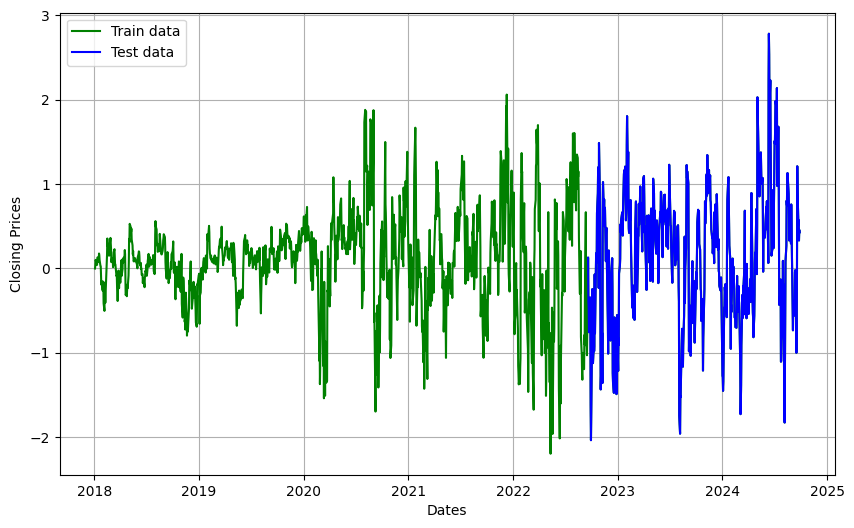

In [20]:
train_data, test_data = ts_diff[:int(len(ts_diff)*0.7)], ts_diff[int(len(ts_diff)*0.7):]
test_data_df=df_close[int(len(df_close)*0.7)+1:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ts_diff, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
print(train_data)
print(test_data)
print(test_data_df)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2056.494, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=710.964, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1311.608, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2086.640, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=709.017, Time=1.54 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=710.846, Time=2.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=710.581, Time=1.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=708.898, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=710.732, Time=0.73 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1005.007, Time=0.47 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=712.567, Time=1.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=709.480, Time=0.14 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.935 seconds
                               SARIMAX Results                                
Dep. Variable:   

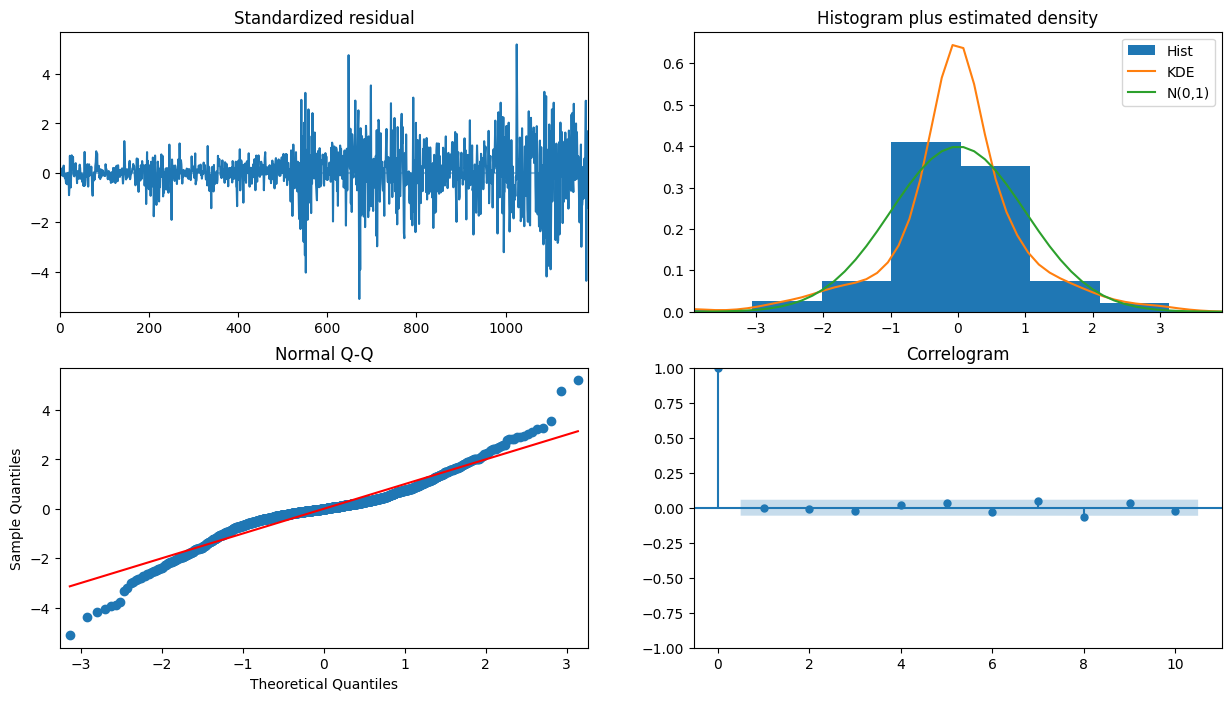

In [21]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal ' # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [22]:
model = ARIMA(train_data, order=(1, 0, 1))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1186
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -350.449
Date:                Sat, 19 Oct 2024   AIC                            708.898
Time:                        13:20:21   BIC                            729.212
Sample:                             0   HQIC                           716.554
                               - 1186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0929      0.059      1.576      0.115      -0.023       0.208
ar.L1          0.8468      0.013     65.821      0.000       0.822       0.872
ma.L1         -0.0723      0.023     -3.189      0.0

predicted=-0.222260, expected=0.127056
predicted=0.121355, expected=-0.381721
predicted=-0.297879, expected=-0.473763
predicted=-0.373922, expected=-0.756263
predicted=-0.607336, expected=-0.587605
predicted=-0.468318, expected=-0.344898
predicted=-0.268138, expected=-0.587221
predicted=-0.468263, expected=-1.629188
predicted=-1.331355, expected=-2.037005
predicted=-1.675309, expected=-1.069773
predicted=-0.869124, expected=-0.343653
predicted=-0.268298, expected=-0.244631
predicted=-0.186631, expected=-0.356227
predicted=-0.278836, expected=-1.122960
predicted=-0.912872, expected=-0.899428
predicted=-0.728295, expected=-0.982593
predicted=-0.797809, expected=-0.929886
predicted=-0.754729, expected=-0.071441
predicted=-0.044479, expected=-0.769681
predicted=-0.621157, expected=-0.031269
predicted=-0.011352, expected=0.179695
predicted=0.162595, expected=0.168973
predicted=0.153761, expected=0.070669
predicted=0.072719, expected=0.656721
predicted=0.555920, expected=0.891070
predicted=0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.610559, expected=1.116030
predicted=0.927713, expected=1.162795
predicted=0.966787, expected=0.880826
predicted=0.735471, expected=1.068393
predicted=0.889994, expected=1.207099
predicted=1.004755, expected=0.570624
predicted=0.481591, expected=0.681296
predicted=0.572575, expected=0.751866
predicted=0.630721, expected=1.465427
predicted=1.218182, expected=1.806129
predicted=1.501494, expected=1.102109
predicted=0.920258, expected=1.381784
predicted=1.151684, expected=0.749203
predicted=0.630327, expected=0.472402
predicted=0.402752, expected=0.421263
predicted=0.360779, expected=0.793378
predicted=0.666907, expected=0.571319
predicted=0.484347, expected=0.811116
predicted=0.681802, expected=0.437099
predicted=0.374156, expected=0.191391
predicted=0.172211, expected=-0.464209
predicted=-0.366566, expected=-0.326637
predicted=-0.253570, expected=-0.201002
predicted=-0.150373, expected=-0.583923
predicted=-0.465229, expected=-0.307936
predicted=-0.238388, expected=-0.339022
p

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.291473, expected=0.115858
predicted=0.111516, expected=-0.157351
predicted=-0.112650, expected=1.063782
predicted=0.888833, expected=0.889353
predicted=0.745933, expected=0.486376
predicted=0.415417, expected=0.686932
predicted=0.579974, expected=0.610482
predicted=0.517399, expected=0.335024
predicted=0.291584, expected=0.206559
predicted=0.186321, expected=0.174781
predicted=0.160270, expected=0.243275
predicted=0.216464, expected=0.568925
predicted=0.483418, expected=0.498321
predicted=0.425610, expected=0.273963
predicted=0.241770, expected=-0.174339
predicted=-0.125656, expected=-0.104441
predicted=-0.068409, expected=0.088552
predicted=0.089660, expected=0.450311
predicted=0.386136, expected=0.668726
predicted=0.565270, expected=0.558153
predicted=0.474718, expected=0.909205
predicted=0.762831, expected=0.901635
predicted=0.756919, expected=0.552154
predicted=0.470215, expected=0.410285
predicted=0.353937, expected=0.133318
predicted=0.126868, expected=0.535884
predic

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=-0.187400, expected=-0.014836
predicted=0.003610, expected=0.179754
predicted=0.163950, expected=0.549023
predicted=0.468285, expected=0.695327
predicted=0.589029, expected=0.496045
predicted=0.424789, expected=0.636654
predicted=0.540818, expected=0.678708
predicted=0.575635, expected=0.288137
predicted=0.253674, expected=0.223808
predicted=0.200640, expected=-0.052164
predicted=-0.026800, expected=-0.245677
predicted=-0.186316, expected=-0.266340
predicted=-0.203405, expected=-0.622288
predicted=-0.497024, expected=-0.508091
predicted=-0.402964, expected=-0.362230
predicted=-0.282752, expected=-0.666502
predicted=-0.533911, expected=-1.211657
predicted=-0.984889, expected=-0.820632
predicted=-0.661796, expected=-0.375921
predicted=-0.294634, expected=-0.244239
predicted=-0.186056, expected=0.285644
predicted=0.250967, expected=0.795545
predicted=0.671499, expected=0.531613
predicted=0.453831, expected=0.846750
predicted=0.713971, expected=1.114944
predicted=0.935863, expect

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.568292, expected=0.394871
predicted=0.343502, expected=0.634121
predicted=0.541463, expected=0.758103
predicted=0.644206, expected=0.252239
predicted=0.225740, expected=0.448820
predicted=0.388286, expected=0.879771
predicted=0.744916, expected=0.767497
predicted=0.652159, expected=0.566345
predicted=0.485787, expected=0.220752
predicted=0.199974, expected=0.348329
predicted=0.305480, expected=-0.029875
predicted=-0.007218, expected=-0.048358
predicted=-0.022519, expected=-0.207070
predicted=-0.153774, expected=-0.259829
predicted=-0.197454, expected=-0.204472
predicted=-0.151722, expected=-0.106860
predicted=-0.071034, expected=-0.251959
predicted=-0.191063, expected=-1.273196
predicted=-1.036551, expected=-1.291165
predicted=-1.052455, expected=-1.452524
predicted=-1.187805, expected=-1.341368
predicted=-1.096422, expected=-0.461157
predicted=-0.365370, expected=-0.454825
predicted=-0.360238, expected=-0.223313
predicted=-0.168536, expected=-0.281266
predicted=-0.216582, 

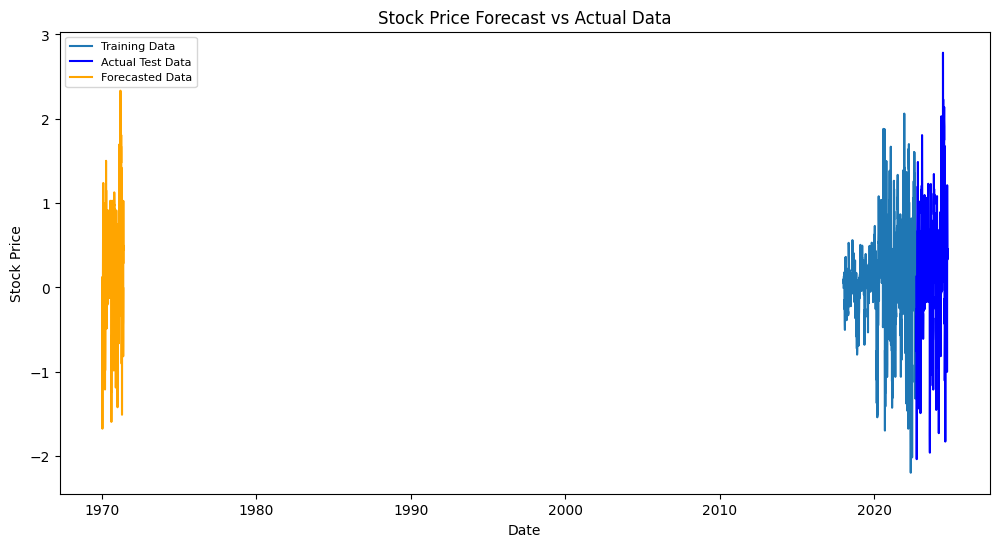

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train_data]
predictions = list()
for t in range(len(test_data_df)):
 model = ARIMA(history, order=(1,0,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test_data[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))





# Plot
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Test Data')
plt.plot(pd.Series(predictions), color='orange', label='Forecasted Data')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10, label='95% Confidence Interval')
plt.title('Stock Price Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

508
508
508
          Date  Actual Price  Forecasted Price
503 2024-09-23    226.470001        218.846885
504 2024-09-24    227.369995        219.632107
505 2024-09-25    226.369995        220.077653
506 2024-09-26    227.520004        220.572684
507 2024-09-27    227.789993        220.866345
Actual vs Forecasted Prices
        Date  Actual Price  Forecasted Price
0 2022-09-21    153.720001        156.141715
1 2022-09-22    152.740005        156.263070
2 2022-09-23    150.429993        155.965191
3 2022-09-26    150.770004        155.591269
4 2022-09-27    151.759995        154.983933
5 2022-09-28    149.839996        154.515615
6 2022-09-29    142.479996        154.247477
7 2022-09-30    138.199997        153.779214
8 2022-10-03    142.449997        152.447859
9 2022-10-04    146.100006        150.772550


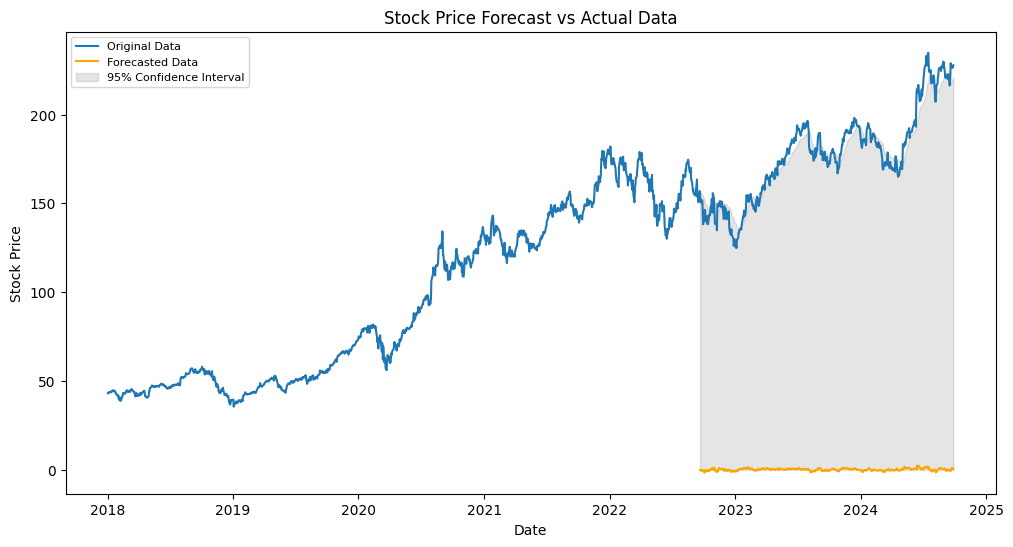

In [24]:
last_known_value = df_ewm.iloc[len(train_data) - 1]


# Convert predictions to original scale
predicted_original = pd.Series(predictions).cumsum() + last_known_value
actual_original=test_data.cumsum()+last_known_value

# Create DataFrame to show actual and forecasted values
forecast_index = test_data_df.index
forecast_series = pd.Series(predictions, index=forecast_index)
print(len(forecast_index))
print(len(test_data_df))
print(len(predicted_original))

results_df = pd.DataFrame({
    'Date': forecast_index,
    'Actual Price': test_data_df.values,
    'Forecasted Price': predicted_original
})
print(results_df.tail())

print("Actual vs Forecasted Prices")
print(results_df.head(10))  # Adjust number of rows if needed

# Plot
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(df_close, label='Original Data')
plt.plot(forecast_series, color='orange', label='Forecasted Data')
plt.fill_between(forecast_index,
                 predicted_original,
                 color='k', alpha=.10, label='95% Confidence Interval')
plt.title('Stock Price Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mse = mean_squared_error(test_data_df.values, predicted_original)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_df.values, predicted_original)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data_df.values, predicted_original))
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(test_data_df.values, predicted_original)* 100
print('MAPE: '+str(mape))

MSE: 38.86234982843614
MAE: 5.0608429715976895
RMSE: 6.233967422792338
MAPE: 2.8837308564705575


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error